GIS - EXAM - FINAL PROJECT

QUESTION 1:

IMPORT BASIC AND REQUIRED LIBRARIES

In [47]:
!pip install pykrige
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_map_utils as mapu # for North Arrow
from matplotlib_scalebar.scalebar import ScaleBar # to Draw Scalebar
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid

SET WORKING DIRECTORY

In [50]:
path = r"C:/GIS/GIS FINAL PROJECT/FINAL SUBMISSION/QUES.1/FieldWork"
os.chdir(path)


IMPORT FIELD DATA FROM CSV FILE

In [50]:
fname = 'Field_Data.csv'
a = pd.read_csv(fname1)

CREATE GEODATAFRAME POINT FROM CSV FILE,
CREATE GEOMETRY COLUMN FROM LAT AND LON COLUMNS and
SET CRS EPSG:26915 

In [62]:
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))
jeffas.crs = 'EPSG:26915'  # Example: WGS84

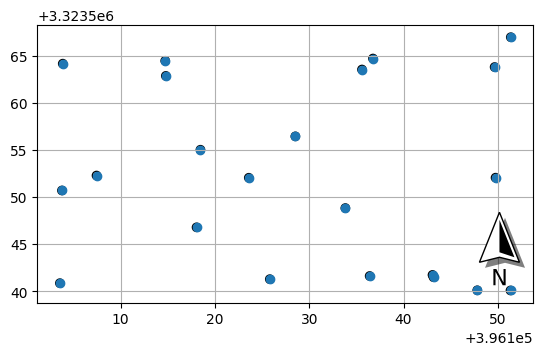

In [64]:
fig,ax = plt.subplots()
jeffas.plot(ax=ax,facecolor='none',edgecolor='black')
jeffas.plot(ax=ax)
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.show()

In [68]:
x = list(jeffas.geometry.x)
y = list(jeffas.geometry.y)
z = list(jeffas.Z)

ADOPT BOUNDS TO DO INTERPOLATION, FIRST GET THE BOUNDS OF JEFFERSON COUNTY TO CREATE A GRID OF SIZE DELTA

LETS SAY GRID SIZE IS 500m x 500m

In [70]:
delta = 500 # create 500 m x 500 m grid
xmin, ymin, xmax, ymax = jeffas.total_bounds
print(xmin, ymin, xmax,ymax)
gridx = np.arange(xmin,(xmax+delta),delta)
gridy = np.arange(ymin,(ymax+delta),delta)

396103.5592 3323540.109 396151.3764 3323566.964


Perform Ordinary Kriging to Identify Best Variogram Model with Actual Data # from Question

**The model that best predicts As compared to measured data will be used. Ideally, the data should be split into training and testing sets, with the model trained on the training data and tested on the independent dataset. Alternatively, cross-validation could be used. However, for simplicity, only training error is used here**

In [72]:
models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []
for m in models:
    ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
    Aspred,ss = ok.execute("grid", x, y)
    err = np.nansum((z-Aspred)**2)
    rmse = np.sqrt(err/len(z))
    varioerr.append(rmse)

# The best variogram gives minimum root mean sq. error

Make a Plot Bars from Error

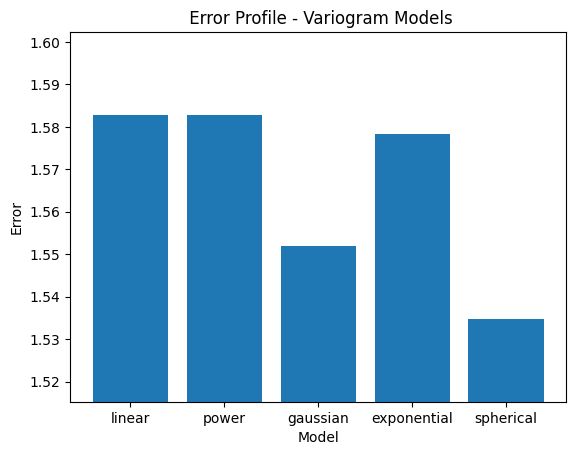

In [74]:
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models,varioerr)
plt.ylim(minlim,maxlim)
plt.ylabel('Error')
plt.xlabel('Model')
plt.title(' Error Profile - Variogram Models')
plt.show()

The best fit model is the Spherical Model.  But you can see any of the other models also perform closely.  (Notice the values of the Y-axis).  

**Perform Ordinary Kriging with the best fit Spherical Model on a grid**

In [77]:
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',  # Automatically fits a spherical model
    verbose=True,
    enable_plotting=False
)

z_pred, ss_pred = ok.execute('grid', gridx, gridy)
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.04978331385683893
Full Sill: 0.12042053827424126
Range: 0.8549420916262509
Nugget: 0.07063722441740233 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



**Write a function for theoretial semi-variogram and Plot the empirical and theoretical variogram clouds**

In [ ]:
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill
    return gamma
theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)
lags = ok.lags  
semivariance = ok.semivariance 
plt.figure()
plt.scatter(lags, semivariance, color='blue', label='Empirical')
plt.plot(lags, theoretical_variogram, color='red', label='Spherical Model')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Empirical Semi-Variogram')
plt.grid()
plt.legend()
plt.show()

**Plot the Predicted Surface on a grid**
from Question

In [ ]:
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, z_pred, levels=20, cmap='inferno')
jeffutm.plot(ax=ax,facecolor='none',edgecolor='black')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.colorbar(contour, label='Predicted As (ppb)')
plt.title('Predicted Arsenic (ppb) Surface',pad=30)
plt.xlabel('Easting (UTM Z15N-NAD83')
plt.ylabel('Northing (UTM Z15N-NAD83')
plt.show()


**Plot the Prediction Standard Error** from Question

In [ ]:
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, np.sqrt(ss_pred), levels=20, cmap='inferno')
jeffutm.plot(ax=ax,facecolor='none',edgecolor='black')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
scalebar = ScaleBar(0.001, "km")  
ax.add_artist(scalebar)
plt.colorbar(contour, label='Standard Error of As Estimate (ppb)')
plt.title('Prediction Standard Error')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

**RESULT:**
The model does near the data points but exhibits higher error when there is no data (yellow regions) A few data points near the south-east quadrant will improve predictions.

**Save the Data of the Contour as an ASCII Grid File.**

In [ ]:
# Save Data for contour as as and ASCII grid file
write_asc_grid(gridx, gridy, z_pred,filename="Asint.asc")